<a href="https://colab.research.google.com/github/Abhaykum123/inception-v1-implementation-scratch/blob/main/GoogLeNet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download samuelcortinhas/sports-balls-multiclass-image-classification

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification
License(s): CC0-1.0
 98% 392M/401M [00:00<00:00, 435MB/s]
100% 401M/401M [00:00<00:00, 469MB/s]


In [ ]:
!unzip /content/sports-balls-multiclass-image-classification.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/cricket_ball/cricket_ball_182.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_183.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_185.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_186.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_187.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_189.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_19.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_190.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_191.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_192.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_195.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_196.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_199.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_200.jpg  
  inflating: /content/train/cricket_ball/cricket_ball_

In [ ]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os

In [ ]:
# Set up directory and parameters
train_dir = '/content/train'
img_size = (224, 224)
batch_size = 32
num_classes = 15

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
train_dir = '/content/train'

data = {'Category': [], 'Image Count': []}

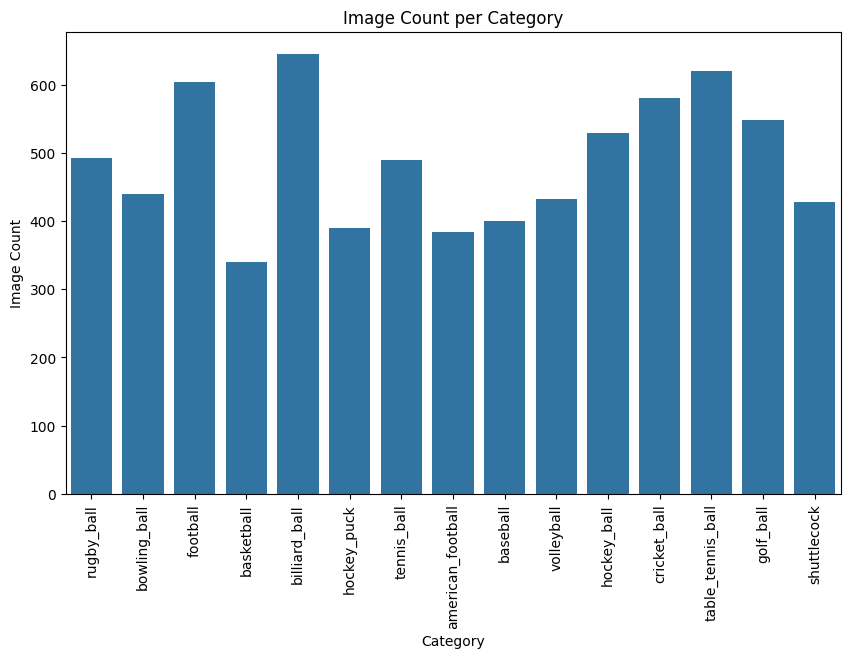

In [ ]:
for sub_dir in os.listdir(train_dir):
  sub_dir_path = os.path.join(train_dir, sub_dir)
  data['Category'].append(sub_dir)
  data['Image Count'].append(len(os.listdir(sub_dir_path)))

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Image Count', data=df)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Image Count')
plt.title('Image Count per Category')
plt.show()

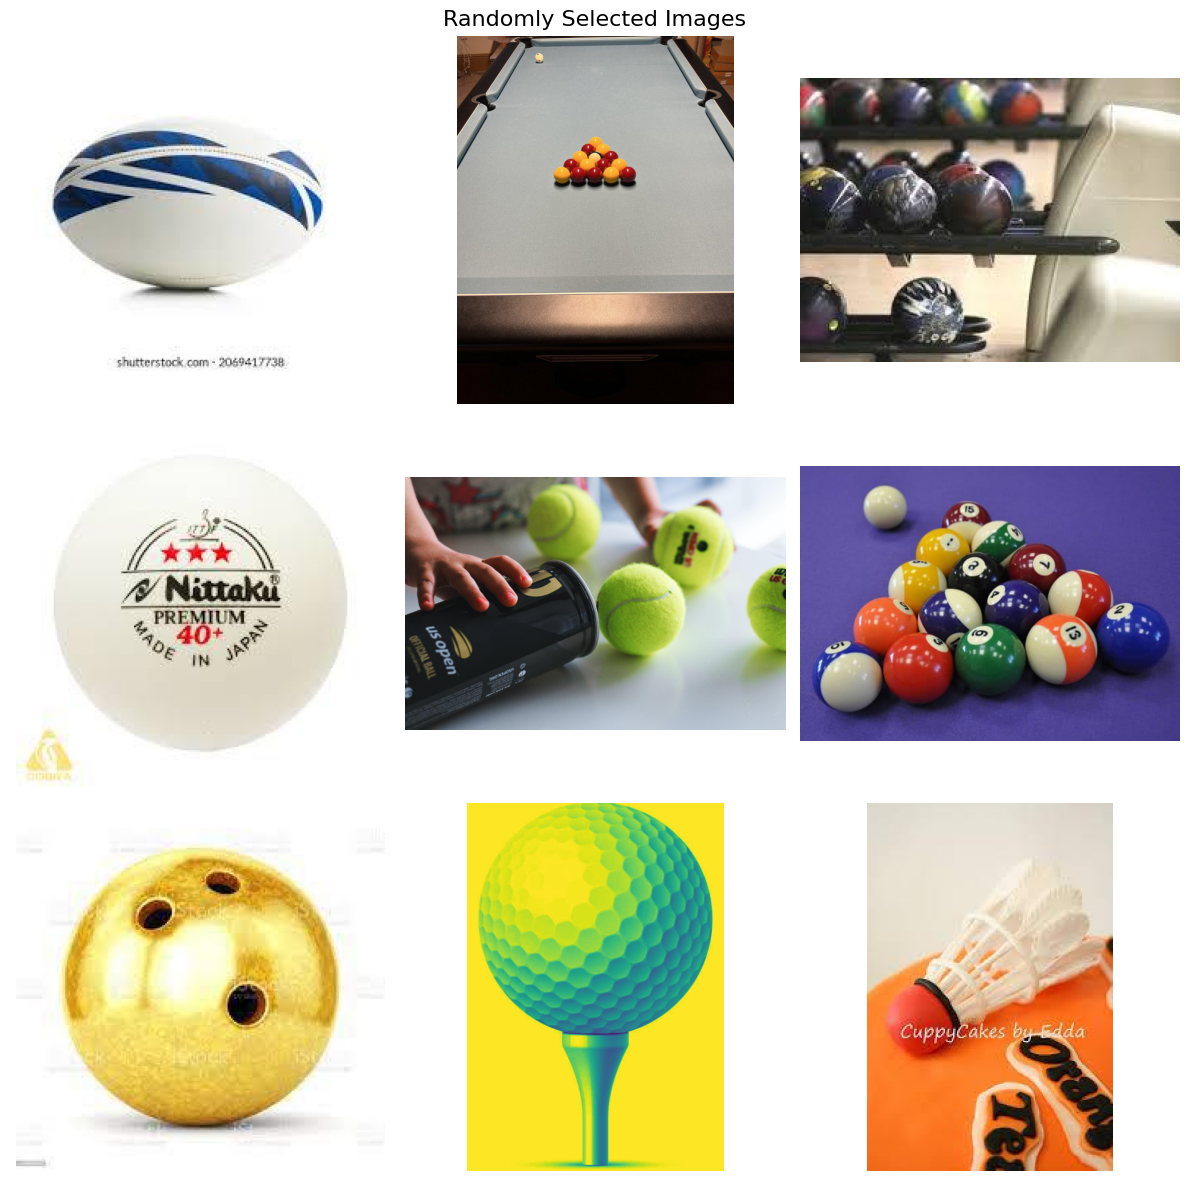

In [ ]:
# Directory path
train_dir = '/content/train'

# Collect all image file paths
all_images = []
for sub_dir in os.listdir(train_dir):
    sub_dir_path = os.path.join(train_dir, sub_dir)
    if os.path.isdir(sub_dir_path):
        for filename in os.listdir(sub_dir_path):
            file_path = os.path.join(sub_dir_path, filename)
            if os.path.isfile(file_path):
                all_images.append(file_path)

# Randomly select 9 images
random_images = random.sample(all_images, 9)

# Plotting the images in a 3x3 grid
plt.figure(figsize=(12, 12))
for i, image_path in enumerate(random_images):
    img = mpimg.imread(image_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle('Randomly Selected Images', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Preprocess the datasets so each label is triplicated for multi-output model
def process_multi_output(image, label):
    return image, (label, label, label)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)
train_dataset = train_dataset.map(process_multi_output)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)
validation_dataset = validation_dataset.map(process_multi_output)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


Found 7328 files belonging to 15 classes.
Using 5863 files for training.
Found 7328 files belonging to 15 classes.
Using 1465 files for validation.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Inception model as defined in the paper
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 convolution
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # 3x3 convolution
    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    # 5x5 convolution
    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    # Max pooling followed by 1x1 convolution
    pool_proj = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Concatenate filters from all branches
    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)

    return output

In [ ]:
# Auxiliary classifier for training (deep supervision)
def auxiliary_classifier(x, num_classes):
  aux = layers.AveragePooling2D((5, 5), strides=(3, 3))(x)
  aux = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(aux)
  aux = layers.Flatten()(aux)
  aux = layers.Dense(1024, activation='relu')(aux)
  aux = layers.Dropout(0.7)(aux)
  aux = layers.Dense(num_classes, activation='softmax')(aux)
  return aux

In [ ]:
# Build the GoogLeNet model with two auxiliary classifiers
def build_googlenet(input_shape, num_classes):
  input_layer = layers.Input(shape = input_shape)

  x = layers.Rescaling(1./255)(input_layer)

  # Initial Convolution and MaxPooling
  x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  # Local Response Normalization (can be replaced with BatchNormalization)
  x = layers.BatchNormalization(name='norm1')(x)

  # Second Convolution and MaxPooling
  x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

  # Inception modules 1 to 4
  x = inception_module(x, 64, 96, 128, 16, 32, 32) # Inception 3a
  x = inception_module(x, 128, 128, 192, 32, 96, 64) # Inception 3b

  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x) # MaxPooling after 3b

  x = inception_module(x, 192, 96, 208, 16, 48, 64) # Inception 4a

  # First auxiliary classifier after the 4th inception model
  aux1 = auxiliary_classifier(x, num_classes)

  x = inception_module(x, 160, 112, 224, 24, 64, 64) # Inception 4b
  x = inception_module(x, 128, 128, 256, 24, 64, 64) # Inception 4c
  x = inception_module(x, 112, 144, 288, 32, 64, 64) # Inception 4d

  # Second auxiliary classifier after the 7th inception model
  aux2 = auxiliary_classifier(x, num_classes)

  x = inception_module(x, 256, 160, 320, 32, 128, 128) # Inception 4e

  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x) # MaxPooling after 4e

  # Inception modules 8 and 9
  x = inception_module(x, 256, 160, 320, 32, 128, 128) # Inception 5a
  x = inception_module(x, 384, 192, 384, 48, 128, 128) # Inception 5b

  # Global Average Pooling and Dropout
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.4)(x)

  # Final output layer (main classifier)
  output_layer = layers.Dense(num_classes, activation='softmax')(x)

  # Define the model with inputs and three output (main + 2 auxiliary)
  model = models.Model(inputs = input_layer, outputs = [output_layer, aux1, aux2])

  return model


In [ ]:
# Model parameters
input_shape = (224, 224, 3) # ImageNet image size
num_classes = 15 # Number of classes for classification

# Build the model
googlenet = build_googlenet(input_shape, num_classes)

In [ ]:
# Print the model summary
googlenet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ rescaling[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm1               │ (None, 56, 56,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │    110,784 │ norm1[0][0]       │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     12,832 │ conv2d_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_2[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_6[0][0],   │
│                     │                   │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                 

 Total params: 10,345,501 (39.46 MB)

 Trainable params: 10,345,373 (39.46 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from tensorflow.keras.utils import plot_model

# Save the model plot to a file with higher resolution
plot_model(
    googlenet,
    to_file="googlenet_model.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=300
)


In [ ]:
googlenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
    loss_weights=[1.0, 0.3, 0.3],
    metrics=['accuracy', 'accuracy', 'accuracy']
)

In [ ]:
history = googlenet.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50
)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 100s 301ms/step - dense_1_accuracy: 0.0762 - dense_1_loss: 2.7603 - dense_3_accuracy: 0.0702 - dense_3_loss: 2.7070 - dense_4_accuracy: 0.0729 - dense_4_loss: 2.7052 - loss: 4.3454 - val_dense_1_accuracy: 0.1461 - val_dense_1_loss: 2.6906 - val_dense_3_accuracy: 0.1208 - val_dense_3_loss: 2.6981 - val_dense_4_accuracy: 0.0942 - val_dense_4_loss: 2.6991 - val_loss: 4.3157
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - dense_1_accuracy: 0.1253 - dense_1_loss: 2.6429 - dense_3_accuracy: 0.1147 - dense_3_loss: 2.6606 - dense_4_accuracy: 0.1115 - dense_4_loss: 2.6628 - loss: 4.2538 - val_dense_1_accuracy: 0.1836 - val_dense_1_loss: 2.6096 - val_dense_3_accuracy: 0.1604 - val_dense_3_loss: 2.6220 - val_dense_4_accuracy: 0.1693 - val_dense_4_loss: 2.6184 - val_loss: 4.1880
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - dense_1_accuracy: 0.1628 - dense_1_loss: 2.5599 - dense_3_accuracy: 0.1542 - dense_3_loss: 2.5782 - dense_4_accuracy

Making predictions on validation dataset...
Processed batch 1
Processed batch 11
Processed batch 21
Processed batch 31
Processed batch 41

Validation Accuracy: 0.5549


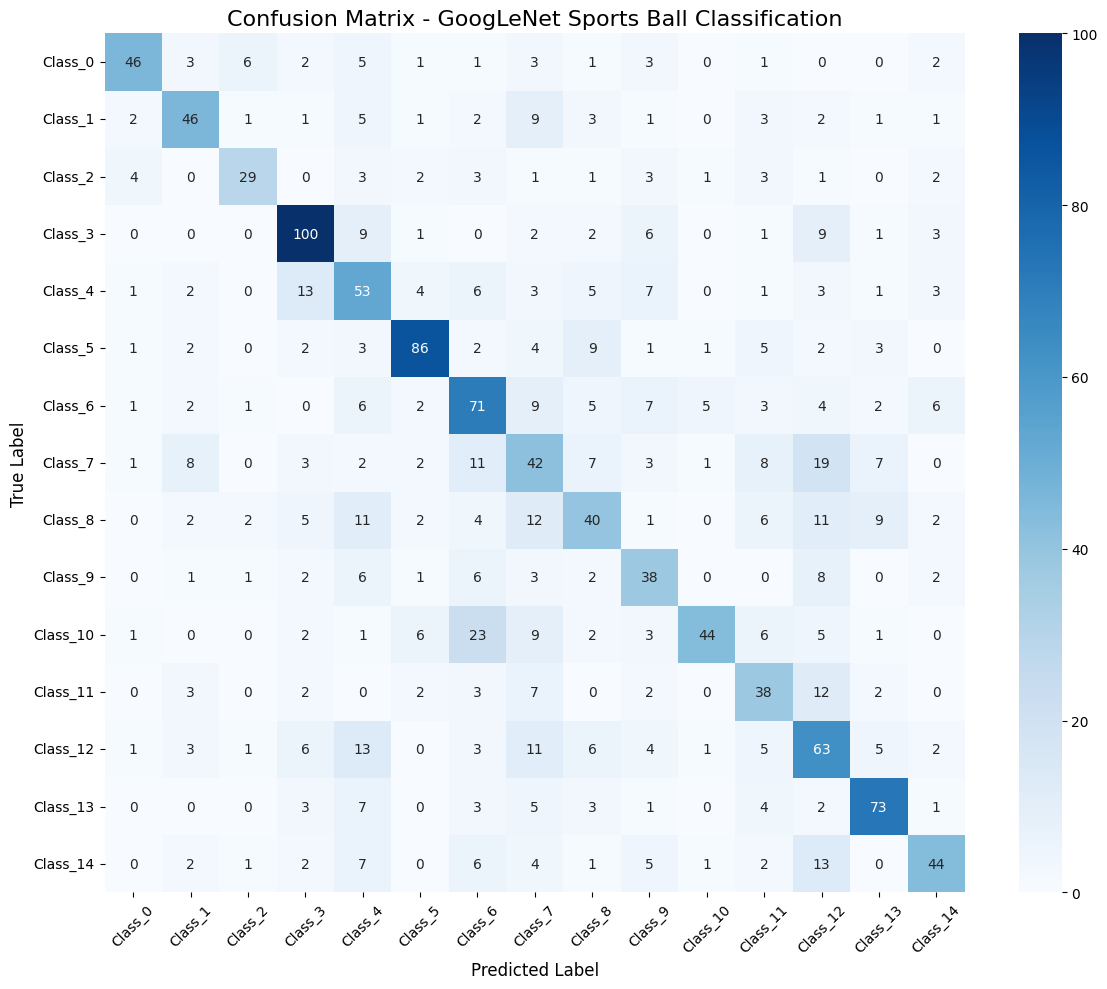


Classification Report:
              precision    recall  f1-score   support

     Class_0       0.79      0.62      0.70        74
     Class_1       0.62      0.59      0.61        78
     Class_2       0.69      0.55      0.61        53
     Class_3       0.70      0.75      0.72       134
     Class_4       0.40      0.52      0.45       102
     Class_5       0.78      0.71      0.74       121
     Class_6       0.49      0.57      0.53       124
     Class_7       0.34      0.37      0.35       114
     Class_8       0.46      0.37      0.41       107
     Class_9       0.45      0.54      0.49        70
    Class_10       0.81      0.43      0.56       103
    Class_11       0.44      0.54      0.48        71
    Class_12       0.41      0.51      0.45       124
    Class_13       0.70      0.72      0.71       102
    Class_14       0.65      0.50      0.56        88

    accuracy                           0.55      1465
   macro avg       0.58      0.55      0.56      1465
we

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to get true labels and predicted labels from the validation dataset
def get_predictions_and_labels(dataset, model):
    true_labels = []
    pred_labels = []

    print("Making predictions on validation dataset...")

    for batch_num, (images, labels) in enumerate(dataset):
        batch_true_labels = labels[0].numpy()
        true_labels.extend(batch_true_labels)

        predictions = model.predict(images, verbose=0)

        # Use main classifier output (first output)
        main_predictions = predictions[0]
        batch_pred_labels = np.argmax(main_predictions, axis=1)
        pred_labels.extend(batch_pred_labels)

        # Print progress
        if batch_num % 10 == 0:
            print(f"Processed batch {batch_num + 1}")

    return np.array(true_labels), np.array(pred_labels)

# Get predictions on validation dataset
y_true, y_pred = get_predictions_and_labels(validation_dataset, googlenet)

# Calculate accuracy
accuracy = np.mean(y_true == y_pred)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names (you may want to replace these with actual sport names)
class_names = [f'Class_{i}' for i in range(num_classes)]

# Plot confusion matrix using matplotlib and seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - GoogLeNet Sports Ball Classification', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Calculate per-class accuracy
print("\nPer-class Accuracy:")
for i in range(num_classes):
    class_mask = y_true == i
    if np.sum(class_mask) > 0:
        class_accuracy = np.mean(y_pred[class_mask] == y_true[class_mask])
        print(f"{class_names[i]}: {class_accuracy:.4f}")


In [ ]:
# Additional evaluation metrics
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=range(num_classes)
)

# Create a summary dataframe
import pandas as pd

results_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("Detailed Performance Metrics:")
print(results_df.round(4))

# Calculate macro and weighted averages
macro_avg = precision_recall_fscore_support(y_true, y_pred, average='macro')
weighted_avg = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f"\nMacro Average - Precision: {macro_avg[0]:.4f}, Recall: {macro_avg[1]:.4f}, F1: {macro_avg[2]:.4f}")
print(f"Weighted Average - Precision: {weighted_avg[0]:.4f}, Recall: {weighted_avg[1]:.4f}, F1: {weighted_avg[2]:.4f}")


Detailed Performance Metrics:
       Class  Precision  Recall  F1-Score  Support
0    Class_0     0.7931  0.6216    0.6970       74
1    Class_1     0.6216  0.5897    0.6053       78
2    Class_2     0.6905  0.5472    0.6105       53
3    Class_3     0.6993  0.7463    0.7220      134
4    Class_4     0.4046  0.5196    0.4549      102
5    Class_5     0.7818  0.7107    0.7446      121
6    Class_6     0.4931  0.5726    0.5299      124
7    Class_7     0.3387  0.3684    0.3529      114
8    Class_8     0.4598  0.3738    0.4124      107
9    Class_9     0.4471  0.5429    0.4903       70
10  Class_10     0.8148  0.4272    0.5605      103
11  Class_11     0.4419  0.5352    0.4841       71
12  Class_12     0.4091  0.5081    0.4532      124
13  Class_13     0.6952  0.7157    0.7053      102
14  Class_14     0.6471  0.5000    0.5641       88

Macro Average - Precision: 0.5825, Recall: 0.5519, F1: 0.5591
Weighted Average - Precision: 0.5785, Recall: 0.5549, F1: 0.5588


Available loss keys: ['dense_1_loss', 'dense_3_loss', 'dense_4_loss']


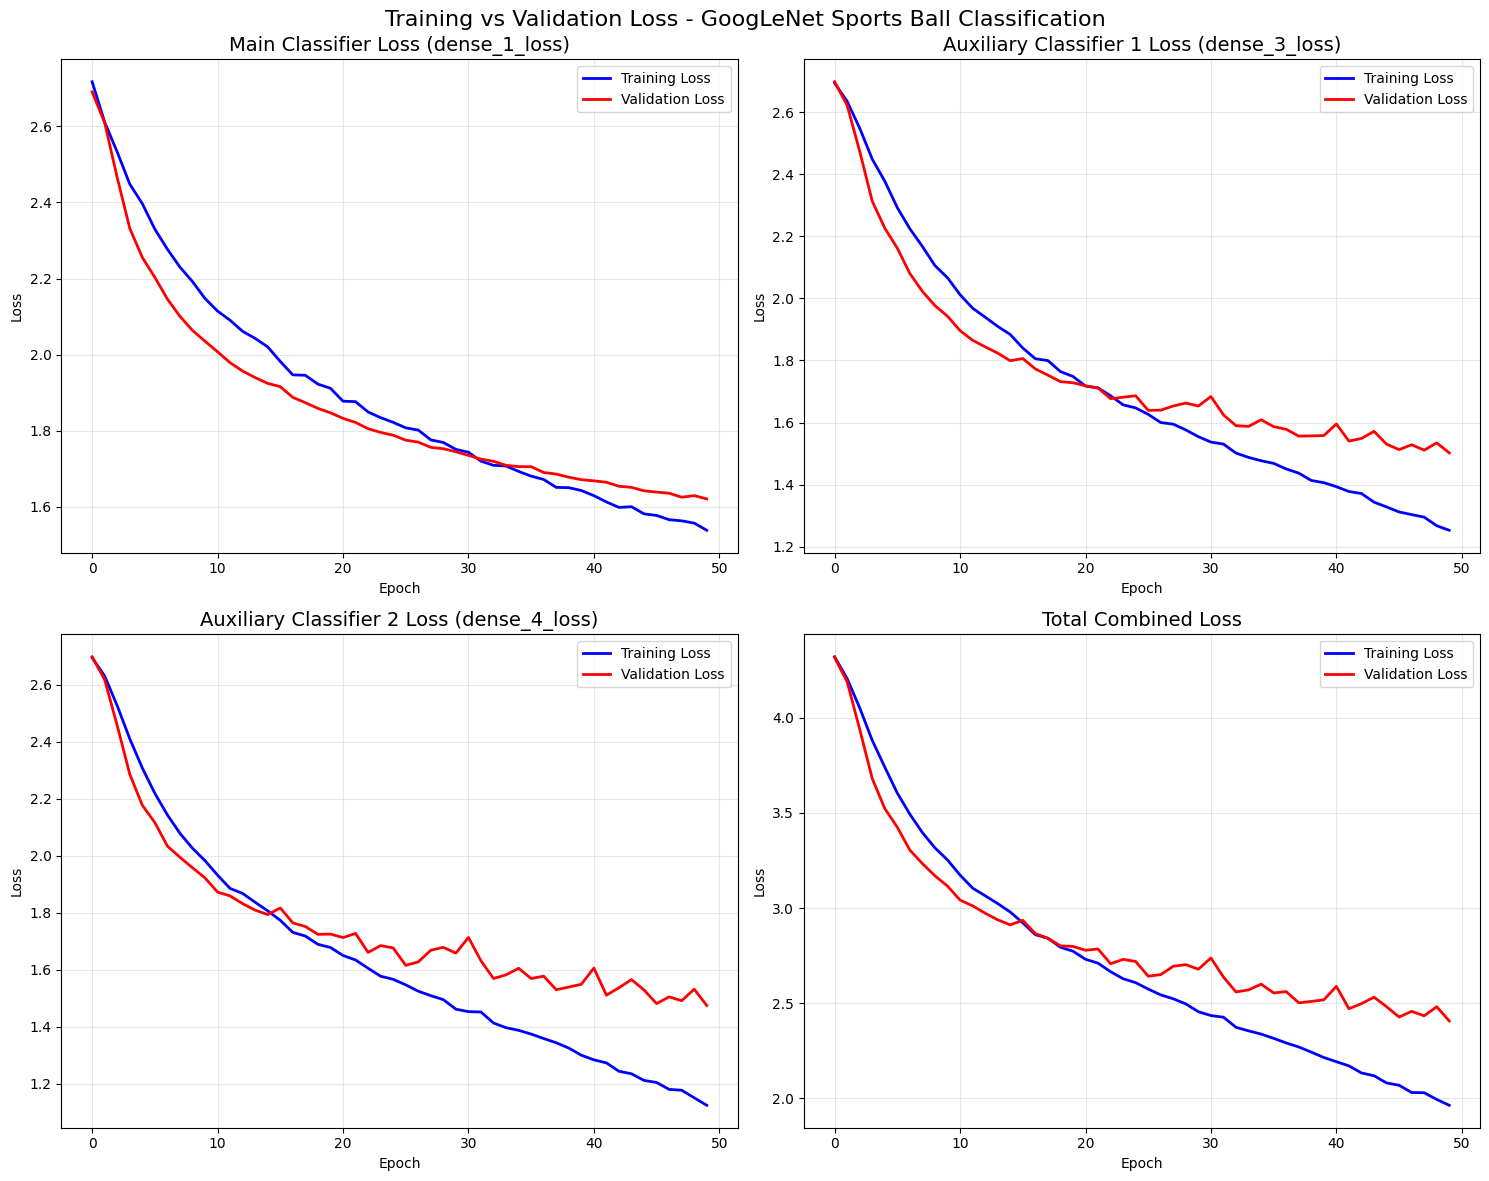

In [ ]:
def plot_loss_comparison_manual(history):
    """
    Plot training loss vs validation loss with manually specified keys
    """
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Training vs Validation Loss - GoogLeNet Sports Ball Classification', fontsize=16)

    # Get all available loss keys (excluding 'loss' and validation keys)
    loss_keys = [k for k in history.history.keys() if 'loss' in k and 'val' not in k and k != 'loss']
    print(f"Available loss keys: {loss_keys}")

    # Try to plot with available keys
    if len(loss_keys) >= 3:
        # Main classifier loss (first output layer)
        main_key = loss_keys[0]
        axes[0, 0].plot(history.history[main_key], 'b-', label='Training Loss', linewidth=2)
        axes[0, 0].plot(history.history[f'val_{main_key}'], 'r-', label='Validation Loss', linewidth=2)
        axes[0, 0].set_title(f'Main Classifier Loss ({main_key})', fontsize=14)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # First auxiliary classifier loss
        aux1_key = loss_keys[1]
        axes[0, 1].plot(history.history[aux1_key], 'b-', label='Training Loss', linewidth=2)
        axes[0, 1].plot(history.history[f'val_{aux1_key}'], 'r-', label='Validation Loss', linewidth=2)
        axes[0, 1].set_title(f'Auxiliary Classifier 1 Loss ({aux1_key})', fontsize=14)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Second auxiliary classifier loss
        aux2_key = loss_keys[2]
        axes[1, 0].plot(history.history[aux2_key], 'b-', label='Training Loss', linewidth=2)
        axes[1, 0].plot(history.history[f'val_{aux2_key}'], 'r-', label='Validation Loss', linewidth=2)
        axes[1, 0].set_title(f'Auxiliary Classifier 2 Loss ({aux2_key})', fontsize=14)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # Combined/Total loss (this should always be available)
    axes[1, 1].plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[1, 1].plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[1, 1].set_title('Total Combined Loss', fontsize=14)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Call the function
plot_loss_comparison_manual(history)


Final Training Loss: 1.9636
Final Validation Loss: 2.4066


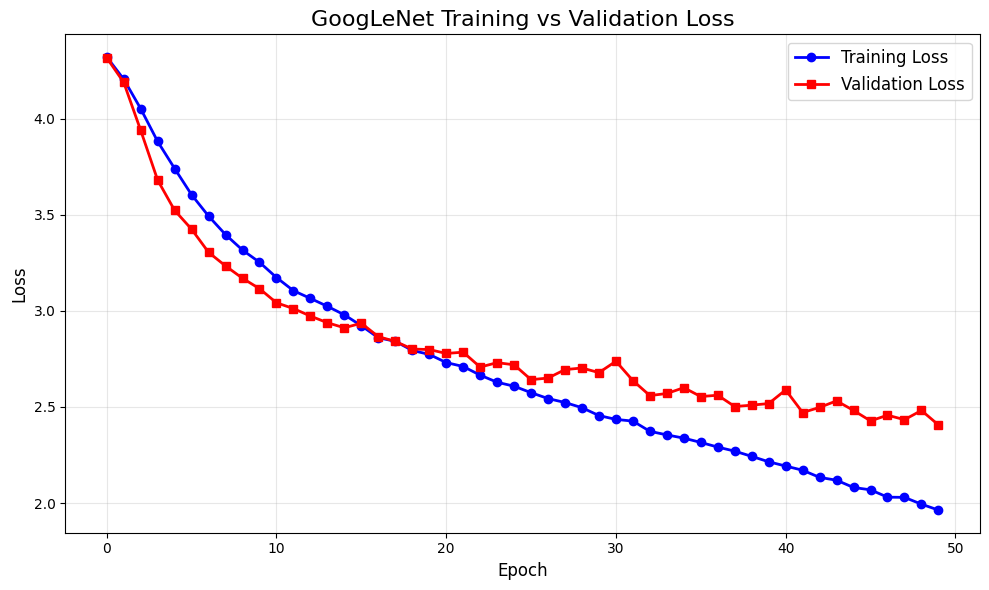

In [ ]:
def plot_simple_loss(history):
    plt.figure(figsize=(10, 6))

    plt.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2, marker='o')
    plt.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s')

    plt.title('GoogLeNet Training vs Validation Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

    # Print final values
    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

    plt.tight_layout()
    plt.show()

# This should definitely work
plot_simple_loss(history)
